In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip -d /content/dataset



Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: /content/dataset/COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: /content/dataset/COVID-19_Radiography

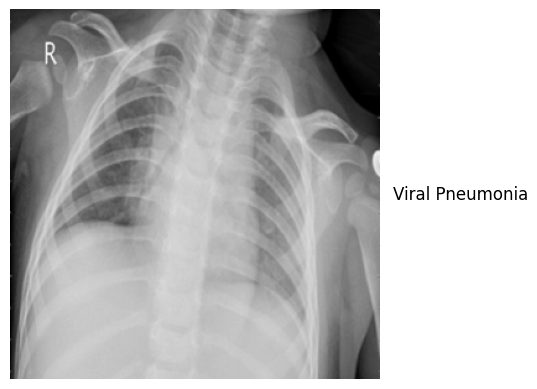

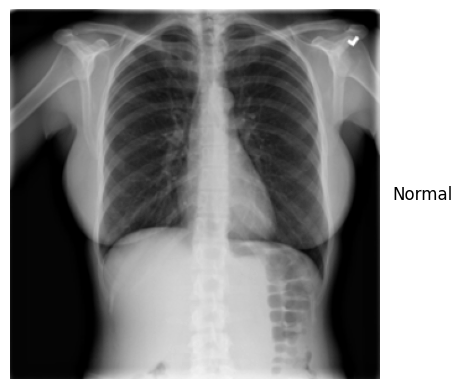

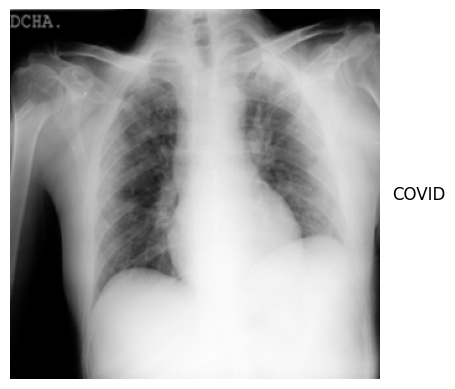

In [15]:

import os
from PIL import Image
import matplotlib.pyplot as plt

image_paths = [
    "/content/dataset/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1014.png",
    "/content/dataset/COVID-19_Radiography_Dataset/Normal/images/Normal-9877.png",
    "/content/dataset/COVID-19_Radiography_Dataset/COVID/images/COVID-1036.png"
]
labels = ["Viral Pneumonia", "Normal", "COVID"]

for image_path, label in zip(image_paths, labels):
    img = Image.open(image_path)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.text(img.size[0] + 10, img.size[1] / 2, label, fontsize=12, ha='left', va='center')
    plt.show()

The dataset has thousands of images of medical scans demonstrating differentt possible medical conditions. The states are COVID-positive, normal (disease free), pneumonia, and lung-opacity (other disease, non-normal). The readme demonstrates that the dataset was created during the COVID-panedmic. The purpose of the dataset would be to create a system to better analyze tests for COVID-positivity, during a time of uncertainty in diagnosis methodology. This dataset would benefit researchers, especially those focused on communities with less access to other testing methodology.

In [26]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224, 3)

def build_transfer_model():
    base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_transfer_model()

base_dir = '/content/dataset/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

unified_dir = '/content/dataset/all_images/class_0'
os.makedirs(unified_dir, exist_ok=True)

for category in categories:
    category_images_dir = os.path.join(base_dir, category, 'images')
    if os.path.exists(category_images_dir):
        for img_file in os.listdir(category_images_dir):
            img_path = os.path.join(category_images_dir, img_file)
            symlink_path = os.path.join(unified_dir, f"{category}_{img_file}")
            if not os.path.exists(symlink_path):
                os.symlink(img_path, symlink_path)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/dataset/all_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    '/content/dataset/all_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator
)

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')



Found 42019 images belonging to 4 classes.
Found 10503 images belonging to 4 classes.
Epoch 1/2
  21/1314 ━━━━━━━━━━━━━━━━━━━━ 35:22 2s/step - accuracy: 0.2744 - loss: -12.0792

KeyboardInterrupt: 

In [24]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (150, 150, 3)

def build_fast_cnn():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_fast_cnn()

base_dir = '/content/dataset/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

unified_dir = '/content/dataset/all_images'
covid_dir = os.path.join(unified_dir, 'COVID')
non_covid_dir = os.path.join(unified_dir, 'Non-COVID')
os.makedirs(covid_dir, exist_ok=True)
os.makedirs(non_covid_dir, exist_ok=True)

for category in categories:
    category_images_dir = os.path.join(base_dir, category, 'images')
    if os.path.exists(category_images_dir):
        for img_file in os.listdir(category_images_dir):
            img_path = os.path.join(category_images_dir, img_file)
            if category == 'COVID':
                symlink_path = os.path.join(covid_dir, img_file)
            else:
                symlink_path = os.path.join(non_covid_dir, img_file)
            if not os.path.exists(symlink_path):
                os.symlink(img_path, symlink_path)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    unified_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    unified_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=validation_generator
)

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')



Found 42019 images belonging to 4 classes.
Found 10503 images belonging to 4 classes.
Epoch 1/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1137s 2s/step - accuracy: 0.3305 - loss: -94977556480.0000 - val_accuracy: 0.3341 - val_loss: -3988435501056.0000
Epoch 2/2
657/657 ━━━━━━━━━━━━━━━━━━━━ 1065s 2s/step - accuracy: 0.3307 - loss: -16241475452928.0000 - val_accuracy: 0.3341 - val_loss: -119856070393856.0000
165/165 ━━━━━━━━━━━━━━━━━━━━ 96s 582ms/step - accuracy: 0.3320 - loss: -120345738608640.0000
Validation Loss: -119856070393856.0000
Validation Accuracy: 0.3341


In [31]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (150, 150, 3)

def build_fast_cnn():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_fast_cnn()

base_dir = '/content/dataset/COVID-19_Radiography_Dataset'
categories = ['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

unified_dir = '/content/dataset/all_images'
covid_dir = os.path.join(unified_dir, 'COVID')
non_covid_dir = os.path.join(unified_dir, 'Non-COVID')
os.makedirs(covid_dir, exist_ok=True)
os.makedirs(non_covid_dir, exist_ok=True)

for category in categories:
    category_images_dir = os.path.join(base_dir, category, 'images')
    if os.path.exists(category_images_dir):
        for img_file in os.listdir(category_images_dir):
            img_path = os.path.join(category_images_dir, img_file)
            symlink_path = os.path.join(covid_dir if category == 'COVID' else non_covid_dir, img_file)
            if not os.path.exists(symlink_path):
                os.symlink(img_path, symlink_path)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    unified_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    unified_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')



Found 42019 images belonging to 4 classes.
Found 10503 images belonging to 4 classes.
Epoch 1/5
 19/657 ━━━━━━━━━━━━━━━━━━━━ 21:32 2s/step - accuracy: 0.3370 - loss: -162.0333

KeyboardInterrupt: 

The three model approaches used are a CNN basic model, a RESNET model incorporating transfer learning, and a CNN-composite model using self-propogated augmeneted data for learning. All three attempt to classify images as either COVID or COVID-free.

The intial model utilizes a basic CNN approach without many modifications. This basic approach results in poor performance and overall accuracy.

The transfer learning approach starts at a lower level of accuracy but becomes much more accurate in its learning.

The augemented CNN-composite model wasa able to perform better with increased learning potential, but a mixed transfer-learning approach with augemented data would likely prove to combine gains from both approaches.

A classification model is limited in its learning potential by the amount of images available. By augementing that data additional learning is possible despite those limitations.